In [1]:
import xlrd
import openpyxl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas import ExcelFile
from sklearn.cluster import KMeans
from sklearn import preprocessing

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import style

# Import Data

In [2]:
raw_dataset = pd.read_excel("../../resources/dataset/preprocessedDataset.xlsx")

In [3]:
raw_dataset.head(2)

,id,reliabilty,popularity,engagment
0,0,0,528,72
1,1,0,477,35


In [4]:
ids = raw_dataset.as_matrix(columns=raw_dataset.columns[:1])
X = raw_dataset.as_matrix(columns=raw_dataset.columns[1:])

print ids.shape
print X.shape

(1143, 1)
(1143, 3)


# Outlier Removal

In [5]:
def outlier_removal_v1(ids, X):
    kmeans = KMeans(n_clusters=4)
    kmeans.fit(preprocessing.scale(X.astype('float64')))
    y = kmeans.labels_
    
    print 'len(X):', len(X)
    print 'len(ids):', len(ids)
    
    bincount_y = np.bincount(y)
    print 'bincount(y):', bincount_y #, '\n'
    print '-----------------------------------------------'
    
    no_outlier_ids = []
    no_outlier_X = []
    
    min_population = +1e9
    less_populated_cluster = 0
    for i in range(0, len(bincount_y)):
        if bincount_y[i] < min_population:
            min_population = bincount_y[i]
            less_populated_cluster = i
        
    
    for i in range(len(y)):
        if y[i] != less_populated_cluster:
            no_outlier_ids.append(ids[i])
            no_outlier_X.append(X[i])

    no_outlier_ids = np.asarray(no_outlier_ids)
    no_outlier_X = np.asarray(no_outlier_X)

    
    
    return np.asarray(no_outlier_ids), np.asarray(no_outlier_X)

In [6]:
def outlier_removal_v2(ids, X):
    from sklearn.ensemble import IsolationForest
    
    estimate = IsolationForest(max_samples=len(X),
                                        contamination=0.20,
                                        random_state=np.random.RandomState(42))
    estimate.fit(X)
    y = estimate.predict(X)
    print y
    
    print 'len(ids):', len(ids)
    print 'data size:', len(X)

    import collections
    bincount_y = collections.Counter(y)
    print 'bincount(y):', bincount_y, '\n'
    print '-----------------------------------------------'
    
    no_outlier_ids = []
    no_outlier_X = []
    
    for i in range(len(y)):
        if y[i] == +1:
            no_outlier_ids.append(ids[i])
            no_outlier_X.append(X[i])

    no_outlier_ids = np.asarray(no_outlier_ids)
    no_outlier_X = np.asarray(no_outlier_X)
    
    return np.asarray(no_outlier_ids), np.asarray(no_outlier_X)

In [7]:
for i in range(0, 3):
    ids, X = outlier_removal_v1(ids, X)
    
# ids, X = outlier_removal_v2(ids, X)

len(X): 1143
len(ids): 1143
bincount(y): [1097    1    1   44]
-----------------------------------------------
len(X): 1142
len(ids): 1142
bincount(y): [  88 1036    9    9]
-----------------------------------------------
len(X): 1133
len(ids): 1133
bincount(y): [990  50   9  84]
-----------------------------------------------


# Kmeans Model and Silhouette Index

n_clusters 3 bincount(y): [977  56  91]
n_clusters 4 bincount(y): [ 89 959  46  30]
n_clusters 5 bincount(y): [ 88  45  91 897   3]
n_clusters 6 bincount(y): [211 738  45  12  85  33]
n_clusters 7 bincount(y): [717  84   9  33  54  12 215]
n_clusters 8 bincount(y): [ 63 717  33  82 207   9  12   1]
n_clusters 9 bincount(y): [609 132  33 208  12   9  79   1  41]


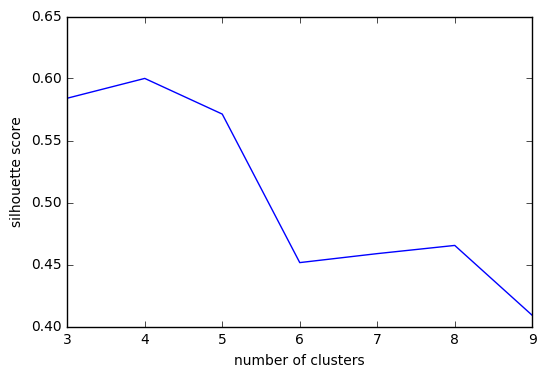

In [8]:
from sklearn.metrics import silhouette_score

sil_x = []
sil_y = []
for n_clusters in range(3, 10):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(preprocessing.scale(X.astype('float64')))
    y = kmeans.labels_
    
    sil_x.append(n_clusters)
    sil_y.append(silhouette_score(preprocessing.scale(X.astype('float64')), y, sample_size=len(X)))

    bincount_y = np.bincount(y)
    print 'n_clusters', n_clusters, 'bincount(y):', bincount_y

plt.plot(sil_x, sil_y)
plt.xlabel('number of clusters')
plt.ylabel('silhouette score')
plt.show()

In [9]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(preprocessing.scale(X.astype('float64')))
y = kmeans.labels_

bincount_y = np.bincount(y)
print 'n_clusters', n_clusters, 'bincount(y):', bincount_y

n_clusters 4 bincount(y): [ 89  46  30 959]


In [10]:
table = pd.DataFrame(index=range(0, n_clusters), columns=['Segment', 'Count', 
                              'Mean_of_Reliability', 'Range_of_Reliability',
                              'Mean_of_Popularity', 'Range_of_Popularity',
                              'Mean_of_Engagement', 'Range_of_Engagement'])

In [11]:
for c in range(0, n_clusters):
    
    cnt = 0
    sum_rl, min_rl, max_rl = 0.0, +1e9, -1e9
    sum_pp, min_pp, max_pp = 0.0, +1e9, -1e9
    sum_pl, min_pl, max_pl = 0.0, +1e9, -1e9
    # print 'C' + str(c), '==============='
    for i in range(0, len(X)):
        if y[i] == c:

            cnt += 1
            
            sum_rl += X[i][0]
            min_rl = min(min_rl, X[i][0]) 
            max_rl = max(max_rl, X[i][0])

            sum_pp += X[i][1]
            min_pp = min(min_pp, X[i][1])
            max_pp = max(max_pp, X[i][1])
            
            sum_pl += X[i][2]
            min_pl = min(min_pl, X[i][2])
            max_pl = max(max_pl, X[i][2])
            # print i, X[i][0], X[i][1], X[i][2], y[i]
            
    table.Segment[c] = 'C' + str(c)
    table.Count[c] = cnt
    
    table.Mean_of_Reliability[c] = '%d' % (sum_rl / cnt)
    table.Range_of_Reliability[c] = '[%9d    %9d]' % (min_rl, max_rl)
    
    table.Mean_of_Popularity[c] = '%d' %(sum_pp / cnt)
    table.Range_of_Popularity[c] = '[%9d    %9d]' % (min_pp, max_pp)
    
    table.Mean_of_Engagement[c] = '%d' % (sum_pl / cnt)
    table.Range_of_Engagement[c] = '[%9d    %9d]' % (min_pl, max_pl)

In [12]:
table

,Segment,Count,Mean_of_Reliability,Range_of_Reliability,Mean_of_Popularity,Range_of_Popularity,Mean_of_Engagement,Range_of_Engagement
0,C0,89,0,[ 0 8],409,[ 35 2162],418,[ 249 858]
1,C1,46,1,[ 0 8],3815,[ 2166 9122],90,[ 1 797]
2,C2,30,13,[ 8 50],771,[ 20 1794],115,[ 1 413]
3,C3,959,0,[ 0 7],407,[ 0 2086],78,[ 1 245]


# Visualizations

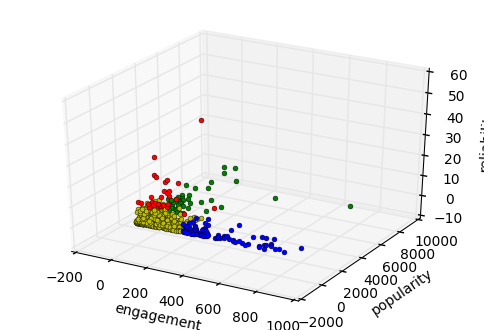

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = ['b', 'g', 'r', 'y', 'c', 'm', 'k', 'w']

for i in range(0, len(y)):
    ax.scatter(X[i,2], X[i,1], X[i,0], c=colors[y[i]], marker='.', s=50, linewidth=0.3)

ax.set_xlabel('engagement')
ax.set_ylabel('popularity')
ax.set_zlabel('reliability')

plt.show()

In [14]:
style.use('ggplot')

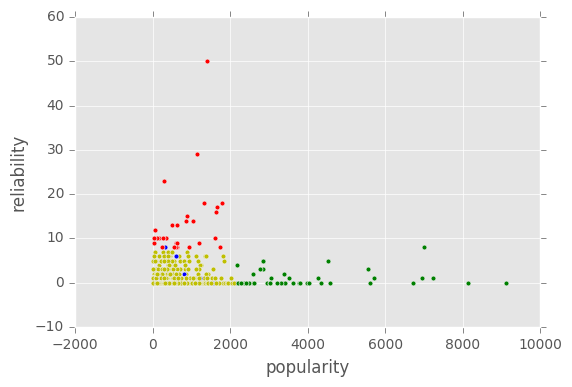

In [18]:
for i in range(0, len(y)):
    plt.scatter(X[i,1], X[i,0], c=colors[y[i]], marker='.', s=50)
plt.xlabel('popularity')
plt.ylabel('reliability')
plt.show()

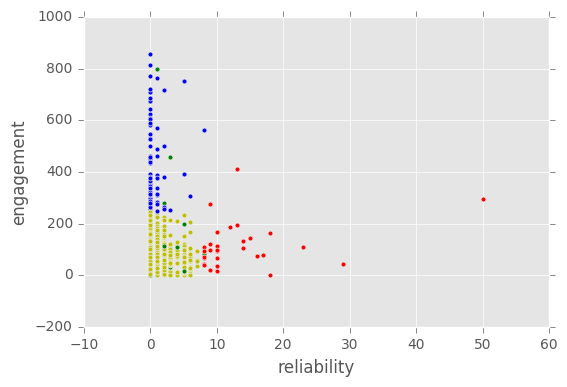

In [19]:
for i in range(0, len(y)):
    plt.scatter(X[i,0], X[i,2], c=colors[y[i]], marker='.', s=50)

plt.xlabel('reliability')
plt.ylabel('engagement')
plt.show()

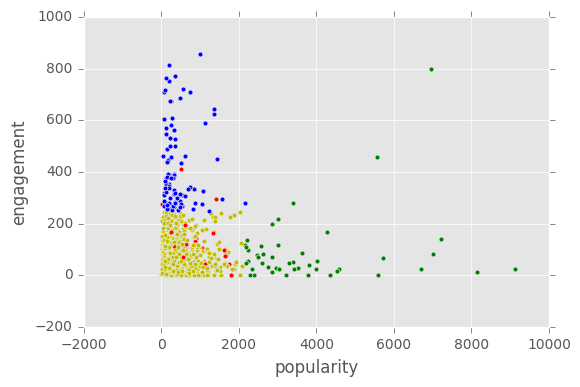

In [20]:
for i in range(0, len(y)):
    plt.scatter(X[i,1], X[i,2], c=colors[y[i]], marker='.', s=50)
plt.xlabel('popularity')
plt.ylabel('engagement')
plt.show()

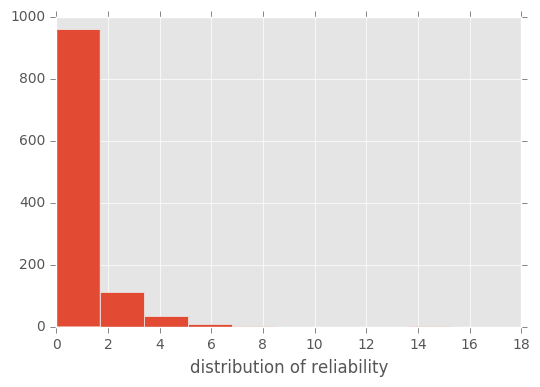

In [18]:
plt.hist(X[:,0])
plt.xlabel('distribution of reliability')
plt.show()

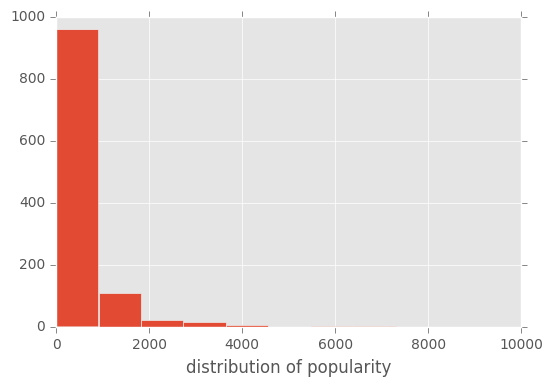

In [19]:
plt.hist(X[:,1])
plt.xlabel('distribution of popularity')
plt.show()

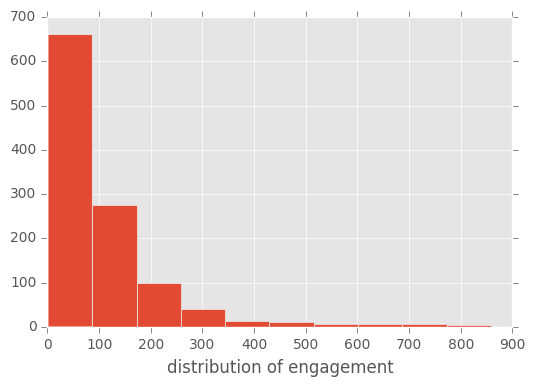

In [20]:
plt.hist(X[:,2])
plt.xlabel('distribution of engagement')
plt.show()